In [883]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pickle
import os
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
transform = transforms.ToTensor()

# train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download = True)
# test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download = True)
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)


train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size


train_dataset, valid_dataset = random_split(train_dataset, [train_size, val_size])

# Load the test dataset as usual
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

d(loss)/d(weights) = d(loss)/d(output) * d(output)/d(weights) = d_output * d(output)/d(weights)

As output = weights * input
d(output)/d(weights) = input

So,
d(loss)/d(weights) = d_output * input

similarly for bias term. 
d(loss)/d(bias) = d_output * 1

In [884]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        # Initialize weights with small random values and biases with zeros
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))

        self.d_biases = None
        self.d_weights = None
    
    def forward(self, inputs):
        # Perform the forward pass
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output
    
    def backward(self, d_output):
        # Compute the gradient for weights, biases, and inputs
        self.d_weights = np.dot(self.inputs.T, d_output)
        self.d_biases = np.sum(d_output, axis=0, keepdims=True)
        d_inputs = np.dot(d_output, self.weights.T)
        
        
        return d_inputs

In [885]:
class BatchNormalization:
    def __init__(self, num_features, momentum=0.9, epsilon=1e-5):
        self.gamma = np.ones(num_features)  # Scale parameter
        self.beta = np.zeros(num_features)   # Shift parameter
        self.momentum = momentum
        self.epsilon = epsilon

        # Running averages for inference
        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)

        # To store intermediate values during forward pass
        self.input = None
        self.mean = None
        self.var = None

    def forward(self, x, training=True):
        if training:
            self.mean = np.mean(x, axis=0)
            self.var = np.var(x, axis=0)
            self.input = x  # Save input for backward pass

            # Normalize the input
            x_normalized = (x - self.mean) / np.sqrt(self.var + self.epsilon)

            # Update running averages
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var

            # Scale and shift
            return self.gamma * x_normalized + self.beta
        else:
            # During inference, use running averages
            x_normalized = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            return self.gamma * x_normalized + self.beta

    def backward(self, d_output):
        N, D = self.input.shape  # Use stored input from forward pass

        # Calculate gradients
        dx_normalized = d_output * self.gamma

        # Gradients for gamma and beta
        dgamma = np.sum(d_output * (self.input - self.mean) / np.sqrt(self.var + self.epsilon), axis=0)
        dbeta = np.sum(d_output, axis=0)

        # Gradients for variance and mean
        dvar = np.sum(dx_normalized * (self.input - self.mean) * -0.5 * np.power(self.var + self.epsilon, -1.5), axis=0)
        dmean = np.sum(dx_normalized * -1 / np.sqrt(self.var + self.epsilon), axis=0) + dvar * np.mean(-2 * (self.input - self.mean), axis=0)

        # Gradients for input
        dx = (dx_normalized / np.sqrt(self.var + self.epsilon)) + (dvar * 2 * (self.input - self.mean) / N) + (dmean / N)

        # Store gradients for the optimizer
        self.d_gamma = dgamma
        self.d_beta = dbeta

        return dx


In [886]:
class ReLU:
    def __init__(self):
        self.cache = None

    # Forward pass
    def forward(self, X):
        self.cache = X
        return np.maximum(0, X)

    # Backward pass
    def backward(self, dout):
        # Gradient of ReLU: 1 where input > 0, else 0
        dX = dout * (self.cache > 0)
        return dX

In [887]:


class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    # Forward pass
    def forward(self, X, training=True):
        if training:
            # Create a mask where each element is 0 with probability `dropout_rate`
            self.mask = (np.random.rand(*X.shape) > self.dropout_rate) / (1 - self.dropout_rate)
            # Apply the mask to the input
            return X * self.mask
        else:
            # During inference, do not apply dropout; use the original values
            return X

    # Backward pass
    def backward(self, dout):
        # During backpropagation, only propagate gradients through the neurons that were not dropped out
        return dout * self.mask


In [888]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, w, dw, id):
        if id not in self.m:
            self.m[id] = np.zeros_like(w)
            self.v[id] = np.zeros_like(w)

        self.t += 1
        self.m[id] = self.beta1 * self.m[id] + (1 - self.beta1) * dw
        self.v[id] = self.beta2 * self.v[id] + (1 - self.beta2) * (dw ** 2)

        m_hat = self.m[id] / (1 - self.beta1 ** self.t)
        v_hat = self.v[id] / (1 - self.beta2 ** self.t)

        w -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return w
    
    def set_learning_rate(self,learning_rate=0.001):
        self.learning_rate = learning_rate


In [889]:
class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, logits):
        # Shift the logits by subtracting the max value for numerical stability
        exp_values = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        # Normalize by dividing by the sum of exponentials along each row
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        return probabilities

    def backward(self, dL_dout):
        # Gradient of the loss with respect to the input logits
        dL_dz = self.output * (dL_dout - np.sum(dL_dout * self.output, axis=1, keepdims=True))
        return dL_dz

In [890]:
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

In [891]:
def cross_entropy_loss(predictions, targets):
    # Clip predictions to avoid log(0) which leads to NaN
    targets_onehot = one_hot_encode(targets, 10)
    # print(f'shape of pred:{predictions.shape} and shape of targets:{targets_onehot.shape}')
    predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
    loss = -np.sum(targets_onehot * np.log(predictions)) / targets_onehot.shape[0]
    return loss

def derivative_cross_entropy(predictions, targets):

    targets_onehot = one_hot_encode(targets, 10)
    dL_dout = (predictions - targets_onehot) / targets_onehot.shape[0]
    return dL_dout

In [892]:
# class FeedForwardNetwork:
#     def __init__(self, layers, optimizer, epochs=10, batch_size=64):
#         self.layers = layers
#         self.optimizer = optimizer
#         self.epochs = epochs
#         self.batch_size = batch_size

#     def train(self, train_loader):
#         for epoch in range(self.epochs):
#             loss = 0
#             for X_train, y_train in train_loader:
#                 X_train = X_train.numpy().reshape(-1, 28*28)
#                 y_train = y_train.numpy()
#                 indices = np.arange(X_train.shape[0])
#                 np.random.shuffle(indices)
#                 X_train = X_train[indices]
#                 y_train = y_train[indices]

#                 for i in range(0, X_train.shape[0], self.batch_size):
#                     X_batch = X_train[i:i + self.batch_size]
#                     y_batch = y_train[i:i + self.batch_size]

#                     # Forward pass through the network
#                     input_data = X_batch
#                     for layer in self.layers:
#                         if isinstance(layer, Dropout):
#                             input_data = layer.forward(input_data, training=True)
#                         else:
#                             input_data = layer.forward(input_data)

#                     # Calculate loss
#                     loss = cross_entropy_loss(input_data, y_batch)
#                     dL_dout = derivative_cross_entropy(input_data, y_batch)

#                     # Backpropagation
#                     for layer in reversed(self.layers):
#                         dL_dout = layer.backward(dL_dout)

#                     # Update weights using Adam
#                     for layer in self.layers:
#                         if hasattr(layer, 'weights'):
#                             layer.weights = self.optimizer.update(layer.weights, layer.d_weights, id(layer.weights))
#                             layer.biases = self.optimizer.update(layer.biases, layer.d_biases, id(layer.biases))

#             print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {loss / len(train_loader):.4f}')


            
#     def test(self, test_loader):
#         correct_predictions = 0
#         total_samples = 0
#         for X_test, y_test in test_loader:
#             total_samples += X_test.shape[0]

#             # Forward pass through the network for the test set
#             X_test = X_test.view(X_test.size(0), -1).numpy()  # Flatten the images
#             y_test = y_test.numpy()

#             # Normalize input data
#             # input_data = X_test.astype(np.float32) / 255.0
#             input_data = X_test

#             for layer in self.layers:
#                 input_data = layer.forward(input_data)

#             # Get predictions by taking the argmax of the output
#             predictions = np.argmax(input_data, axis=1)

#             # Compare predictions with true labels
#             correct_predictions += np.sum(predictions == y_test)

#         # Calculate accuracy
#         accuracy = correct_predictions / total_samples
#         print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [893]:
# class FeedForwardNetwork:
#     def __init__(self, layers, optimizer, epochs=10, batch_size=64):
#         self.layers = layers
#         self.optimizer = optimizer
#         self.epochs = epochs
#         self.batch_size = batch_size

#     def forward_pass(self, X):
#         input_data = X
#         for layer in self.layers:
#             input_data = layer.forward(input_data)
#         return input_data

#     def calculate_loss_and_accuracy(self, loader, training=False):
#         total_loss, correct_predictions, total_samples = 0, 0, 0
#         all_labels, all_preds = [], []

#         for X_batch, y_batch in loader:
#             if training:
#                 X_batch = X_batch.numpy().reshape(-1, 28 * 28)  # Flatten the input for training
#                 y_batch = y_batch.numpy()
#             else:
#                 X_batch = X_batch.view(X_batch.size(0), -1).numpy()  # Flatten for testing/validation
#                 y_batch = y_batch.numpy()

#             input_data = self.forward_pass(X_batch)
#             total_loss += cross_entropy_loss(input_data, y_batch) * X_batch.shape[0]

#             predictions = np.argmax(input_data, axis=1)
#             correct_predictions += np.sum(predictions == y_batch)
#             total_samples += X_batch.shape[0]

#             all_labels.extend(y_batch)
#             all_preds.extend(predictions)

#         accuracy = correct_predictions / total_samples
#         avg_loss = total_loss / total_samples
#         macro_f1 = f1_score(all_labels, all_preds, average='macro')

#         return avg_loss, accuracy, macro_f1

#     def train(self, train_loader, val_loader=None):
#         for epoch in range(self.epochs):
#             model_loss, train_correct, total_train_samples = 0, 0, 0
#             all_train_labels, all_train_preds = [], []

#             macro_f1 = []
#             for X_train, y_train in train_loader:
#                 X_train = X_train.numpy().reshape(-1, 28 * 28)  # Flatten input
#                 y_train = y_train.numpy()

#                 indices = np.arange(X_train.shape[0])
#                 np.random.shuffle(indices)
#                 X_train, y_train = X_train[indices], y_train[indices]

#                 for i in range(0, X_train.shape[0], self.batch_size):
#                     X_batch = X_train[i:i + self.batch_size]
#                     y_batch = y_train[i:i + self.batch_size]

#                     input_data = self.forward_pass(X_batch)

#                     batch_loss = cross_entropy_loss(input_data, y_batch)
#                     model_loss += batch_loss * X_batch.shape[0]
#                     dL_dout = derivative_cross_entropy(input_data, y_batch)

#                     for layer in reversed(self.layers):
#                         dL_dout = layer.backward(dL_dout)

#                     for layer in self.layers:
#                         if hasattr(layer, 'weights'):
#                             layer.weights = self.optimizer.update(layer.weights, layer.d_weights, id(layer.weights))
#                             layer.biases = self.optimizer.update(layer.biases, layer.d_biases, id(layer.biases))

#                     predictions = np.argmax(input_data, axis=1)
#                     train_correct += np.sum(predictions == y_batch)
#                     total_train_samples += y_batch.shape[0]

#                     all_train_labels.extend(y_batch)
#                     all_train_preds.extend(predictions)

#             avg_train_loss = model_loss / total_train_samples
#             train_accuracy = train_correct / total_train_samples
#             train_macro_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

#             # Validation step (if provided)
#             if val_loader:
#                 val_loss, val_accuracy, val_macro_f1 = self.calculate_loss_and_accuracy(val_loader)
#             else:
#                 val_loss, val_accuracy, val_macro_f1 = None, None, None

#             # Print results for the current epoch
#             print(f'Epoch {epoch + 1}/{self.epochs}')
#             print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Macro F1 Score: {train_macro_f1:.4f}')
#             if val_loader:
#                 print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Macro F1 Score: {val_macro_f1:.4f}')
#                 macro_f1.append(val_macro_f1)
#             print('-' * 50)
#             return macro_f1

#     def test(self, test_loader):
#         _, test_accuracy, _ = self.calculate_loss_and_accuracy(test_loader)
#         print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

#     def evaluate_macro_f1(self, valid_loader):
#         all_labels = []
#         all_preds = []

#         # Iterate through the validation data
#         for X_batch, y_batch in valid_loader:
#             X_batch = X_batch.numpy().reshape(-1, 28 * 28)  # Flatten the images
#             y_batch = y_batch.numpy()

#             # Perform forward pass
#             input_data = self.forward_pass(X_batch)

#             # Get predictions
#             predictions = np.argmax(input_data, axis=1)

#             # Collect the true labels and predicted labels
#             all_labels.extend(y_batch)
#             all_preds.extend(predictions)

#         # Compute macro F1 score
#         macro_f1 = f1_score(all_labels, all_preds, average='macro')
#         return macro_f1


In [905]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from torch.optim import SGD
from sklearn.metrics import confusion_matrix

class FeedForwardNetwork:
    def __init__(self, layers, optimizer, scheduler=None, epochs=10, batch_size=64):
        self.layers = layers
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.batch_size = batch_size

    def forward_pass(self, X):
        input_data = X
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data

    def calculate_loss_and_accuracy(self, loader, training=False):
        total_loss, correct_predictions, total_samples = 0, 0, 0
        all_labels, all_preds = [], []

        for X_batch, y_batch in loader:
            if training:
                X_batch = X_batch.numpy().reshape(-1, 28 * 28)  # Flatten the input for training
                y_batch = y_batch.numpy()
            else:
                X_batch = X_batch.view(X_batch.size(0), -1).numpy()  # Flatten for testing/validation
                y_batch = y_batch.numpy()

            input_data = self.forward_pass(X_batch)
            total_loss += cross_entropy_loss(input_data, y_batch) * X_batch.shape[0]

            predictions = np.argmax(input_data, axis=1)
            correct_predictions += np.sum(predictions == y_batch)
            total_samples += X_batch.shape[0]

            all_labels.extend(y_batch)
            all_preds.extend(predictions)

        accuracy = correct_predictions / total_samples
        avg_loss = total_loss / total_samples
        macro_f1 = f1_score(all_labels, all_preds, average='macro')

        return avg_loss, accuracy, macro_f1

    def train(self, train_loader, val_loader=None):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        val_macro_f1s = []

        for epoch in range(self.epochs):
            model_loss, train_correct, total_train_samples = 0, 0, 0
            all_train_labels, all_train_preds = [], []

            for X_train, y_train in train_loader:
                X_train = X_train.numpy().reshape(-1, 28 * 28)  # Flatten input
                y_train = y_train.numpy()

                indices = np.arange(X_train.shape[0])
                np.random.shuffle(indices)
                X_train, y_train = X_train[indices], y_train[indices]

                for i in range(0, X_train.shape[0], self.batch_size):
                    X_batch = X_train[i:i + self.batch_size]
                    y_batch = y_train[i:i + self.batch_size]

                    input_data = self.forward_pass(X_batch)

                    batch_loss = cross_entropy_loss(input_data, y_batch)
                    model_loss += batch_loss * X_batch.shape[0]
                    dL_dout = derivative_cross_entropy(input_data, y_batch)

                    for layer in reversed(self.layers):
                        dL_dout = layer.backward(dL_dout)

                    for layer in self.layers:
                        if hasattr(layer, 'weights'):
                            layer.weights = self.optimizer.update(layer.weights, layer.d_weights, id(layer.weights))
                            layer.biases = self.optimizer.update(layer.biases, layer.d_biases, id(layer.biases))

                    predictions = np.argmax(input_data, axis=1)
                    train_correct += np.sum(predictions == y_batch)
                    total_train_samples += y_batch.shape[0]

                    all_train_labels.extend(y_batch)
                    all_train_preds.extend(predictions)

            avg_train_loss = model_loss / total_train_samples
            train_accuracy = train_correct / total_train_samples
            train_macro_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

            # Validation step (if provided)
            if val_loader:
                val_loss, val_accuracy, val_macro_f1 = self.calculate_loss_and_accuracy(val_loader)
            else:
                val_loss, val_accuracy, val_macro_f1 = None, None, None

            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_macro_f1s.append(val_macro_f1)

            # Learning rate scheduler step
            if self.scheduler:
                self.scheduler.step()

            # Print results for the current epoch
            print(f'Epoch {epoch + 1}/{self.epochs}')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Macro F1 Score: {train_macro_f1:.4f}')
            if val_loader:
                print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Macro F1 Score: {val_macro_f1:.4f}')
            print('-' * 50)

        return train_losses, train_accuracies, val_losses, val_accuracies, val_macro_f1s

    # def plot_results(self, train_losses, train_accuracies, val_losses, val_accuracies, val_macro_f1s):
    #     epochs = range(1, len(train_losses) + 1)
        
    #     plt.figure(figsize=(12, 8))
        
    #     plt.subplot(2, 2, 1)
    #     plt.plot(epochs, train_losses, label='Train Loss')
    #     plt.plot(epochs, val_losses, label='Val Loss')
    #     plt.legend()
    #     plt.title('Loss')

    #     plt.subplot(2, 2, 2)
    #     plt.plot(epochs, train_accuracies, label='Train Accuracy')
    #     plt.plot(epochs, val_accuracies, label='Val Accuracy')
    #     plt.legend()
    #     plt.title('Accuracy')

    #     plt.subplot(2, 2, 3)
    #     plt.plot(epochs, val_macro_f1s, label='Val Macro F1')
    #     plt.legend()
    #     plt.title('Validation Macro F1 Score')

    #     plt.tight_layout()
    #     plt.show()

    def plot_results(self, train_losses, train_accuracies, val_losses, val_accuracies, val_macro_f1s):
        epochs = range(1, len(train_losses) + 1)

        # Create a figure for all the curves in one plot
        plt.figure(figsize=(12, 8))

        # Plot Train and Validation Losses
        plt.plot(epochs, train_losses, label='Train Loss', linestyle='-', color='blue')
        plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--', color='blue')

        # Plot Train and Validation Accuracy
        plt.plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-', color='green')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='green')

        # Plot Validation Macro F1 Score
        plt.plot(epochs, val_macro_f1s, label='Validation Macro F1', linestyle='-', color='orange')

        # Add labels, title, and legend
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.title('Training and Validation Metrics')
        plt.legend()

        # Show the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def plot_confusion_matrix(self, model, val_loader):
        all_labels = []
        all_preds = []

        for X_batch, y_batch in val_loader:
            X_batch = X_batch.numpy().reshape(-1, 28 * 28)  # Flatten the images
            y_batch = y_batch.numpy()

            # Perform forward pass
            input_data = model.forward_pass(X_batch)

            # Get predictions
            predictions = np.argmax(input_data, axis=1)

            all_labels.extend(y_batch)
            all_preds.extend(predictions)

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    def evaluate_model(model, test_loader):
        all_labels = []
        all_preds = []

        # Get predictions for the test set
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.numpy().reshape(-1, 28 * 28)  # Flatten for testing
            y_batch = y_batch.numpy()

            input_data = model.forward_pass(X_batch)
            predictions = np.argmax(input_data, axis=1)

            all_labels.extend(y_batch)
            all_preds.extend(predictions)

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_preds)

        # Calculate sensitivity (recall) and specificity from confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        TP = cm[1, 1]  # True Positives
        TN = cm[0, 0]  # True Negatives
        FP = cm[0, 1]  # False Positives
        FN = cm[1, 0]  # False Negatives

        # Sensitivity (Recall)
        sensitivity = TP / (TP + FN)

        # Specificity
        specificity = TN / (TN + FP)

        # Precision
        precision = precision_score(all_labels, all_preds, average='macro')

        # F1 Score
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")



In [895]:



# Initialize Adam optimizer
adam = Adam(learning_rate=0.0001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)


# Prepare training data
# X_train, y_train = next(iter(train_loader))
# X_train = X_train.numpy().reshape(-1, 28*28)  # Flatten the images
# y_train = y_train.numpy()


X_test, y_test = next(iter(test_loader))
X_test = X_test.numpy().reshape(-1, 28 * 28)  # Flatten the images
y_test = y_test.numpy()




# # Create and train the network
# network = FeedForwardNetwork(layers=layers, optimizer=adam, epochs=5, batch_size=32)

# # network.train(train_loader, val_loader=valid_loader)
# network.evaluate_macro_f1(valid_loader=valid_loader)
    
    

# network.test(test_loader)

# save_model(network)

In [896]:
def save_model(model, folder='pickle', filename='finalized_model.pkl'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    filepath = os.path.join(folder, filename)
    
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved as {filepath}")

def load_model(folder='pickle', filename='finalized_model.pkl'):
    filepath = os.path.join(folder, filename)
    
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filepath}")
    return model

In [897]:
# network = load_model()

Epoch 1/50
Train Loss: 0.5568, Train Accuracy: 0.8133, Train Macro F1 Score: 0.8106
Val Loss: 0.4807, Val Accuracy: 0.8322, Val Macro F1 Score: 0.8340
--------------------------------------------------
Epoch 2/50
Train Loss: 0.4289, Train Accuracy: 0.8544, Train Macro F1 Score: 0.8534
Val Loss: 0.4289, Val Accuracy: 0.8522, Val Macro F1 Score: 0.8531
--------------------------------------------------
Epoch 3/50
Train Loss: 0.3999, Train Accuracy: 0.8667, Train Macro F1 Score: 0.8659
Val Loss: 0.4238, Val Accuracy: 0.8582, Val Macro F1 Score: 0.8584
--------------------------------------------------
Epoch 4/50
Train Loss: 0.3813, Train Accuracy: 0.8750, Train Macro F1 Score: 0.8743
Val Loss: 0.4190, Val Accuracy: 0.8610, Val Macro F1 Score: 0.8619
--------------------------------------------------
Epoch 5/50
Train Loss: 0.3687, Train Accuracy: 0.8786, Train Macro F1 Score: 0.8780
Val Loss: 0.3995, Val Accuracy: 0.8668, Val Macro F1 Score: 0.8669
-----------------------------------------

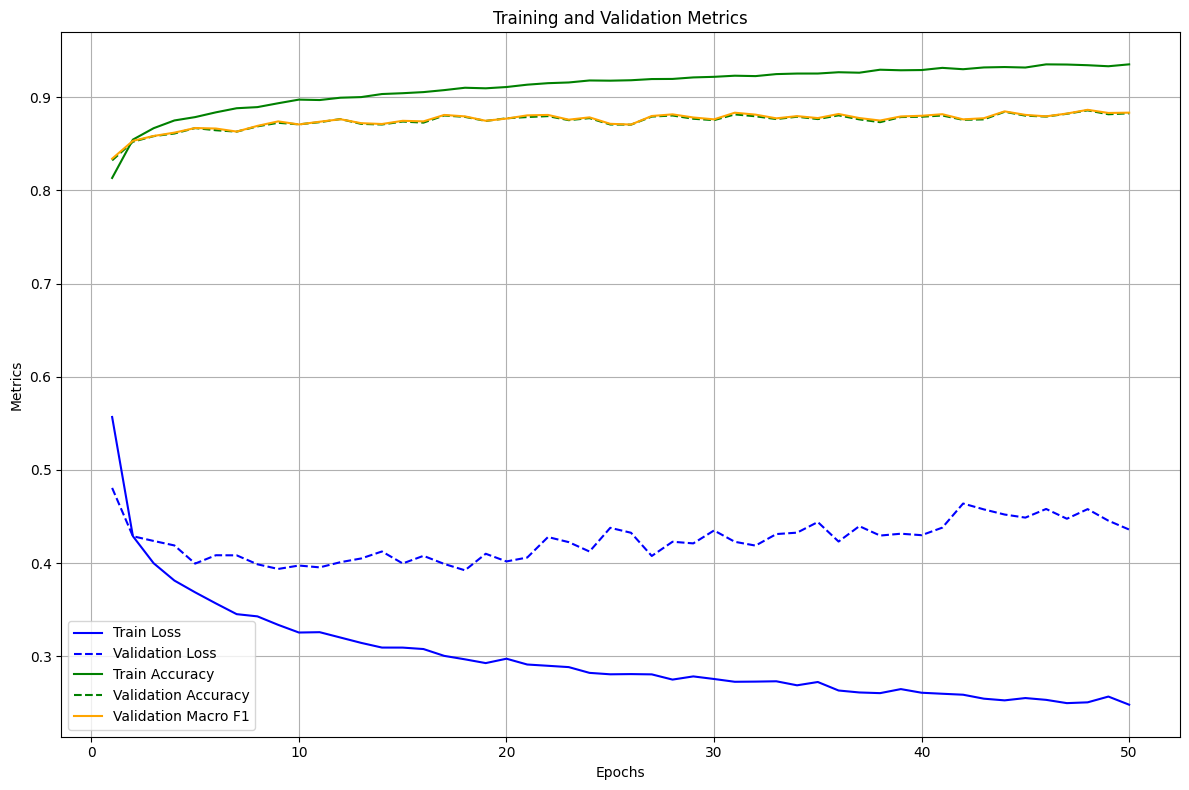

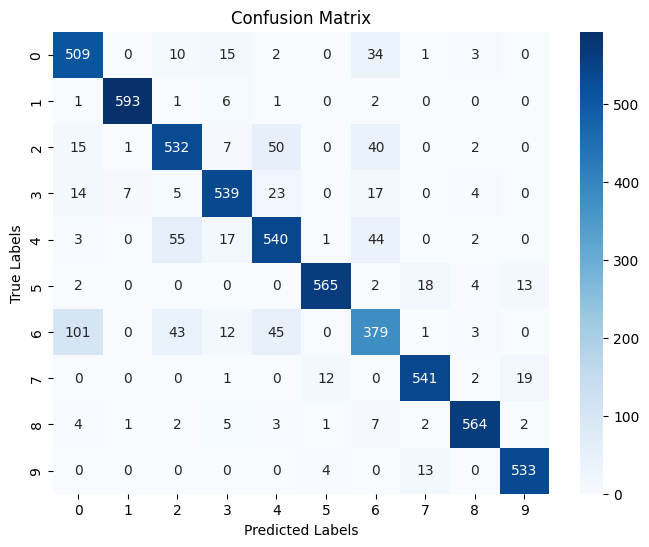

Model saved as pickle/model3_0.005.pkl
Epoch 1/50
Train Loss: 0.2254, Train Accuracy: 0.9440, Train Macro F1 Score: 0.9438
Val Loss: 0.4332, Val Accuracy: 0.8867, Val Macro F1 Score: 0.8881
--------------------------------------------------
Epoch 2/50
Train Loss: 0.2191, Train Accuracy: 0.9478, Train Macro F1 Score: 0.9477
Val Loss: 0.4433, Val Accuracy: 0.8880, Val Macro F1 Score: 0.8893
--------------------------------------------------
Epoch 3/50
Train Loss: 0.2150, Train Accuracy: 0.9498, Train Macro F1 Score: 0.9496
Val Loss: 0.4571, Val Accuracy: 0.8885, Val Macro F1 Score: 0.8892
--------------------------------------------------
Epoch 4/50
Train Loss: 0.2116, Train Accuracy: 0.9499, Train Macro F1 Score: 0.9498
Val Loss: 0.4484, Val Accuracy: 0.8878, Val Macro F1 Score: 0.8888
--------------------------------------------------
Epoch 5/50
Train Loss: 0.2106, Train Accuracy: 0.9507, Train Macro F1 Score: 0.9506
Val Loss: 0.4518, Val Accuracy: 0.8837, Val Macro F1 Score: 0.8843
--

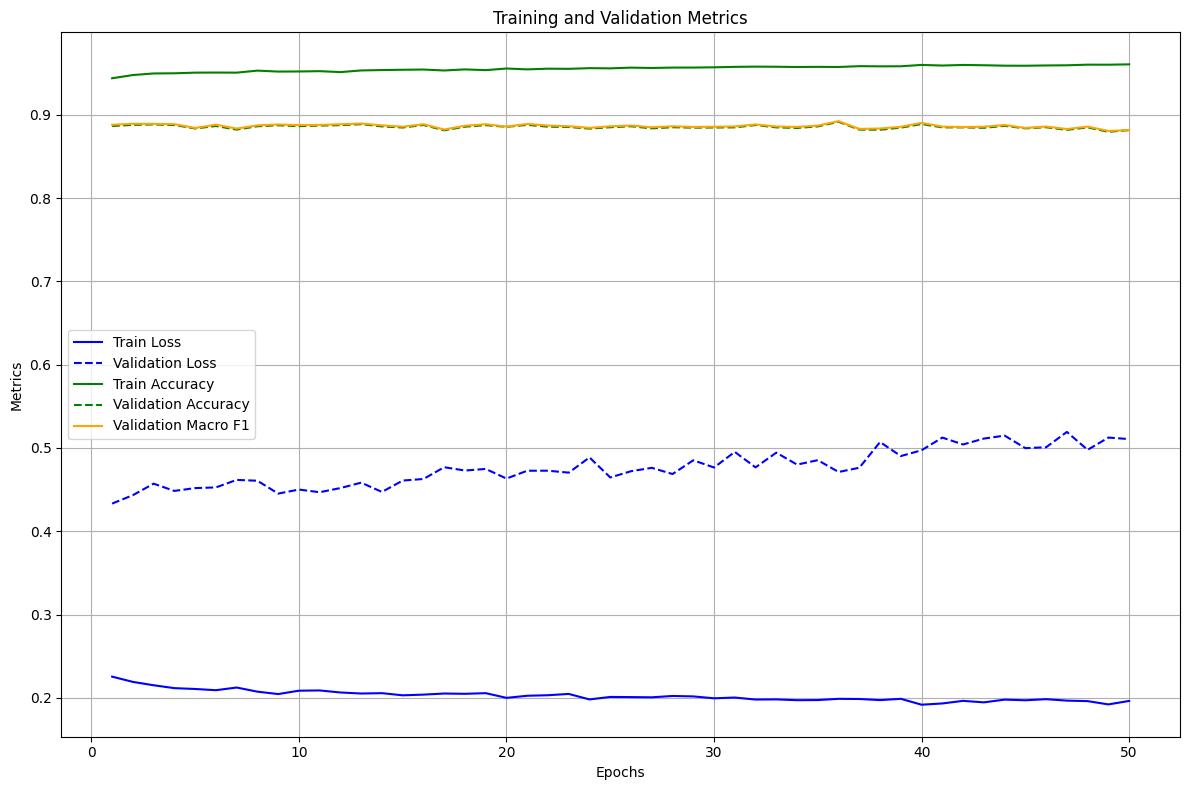

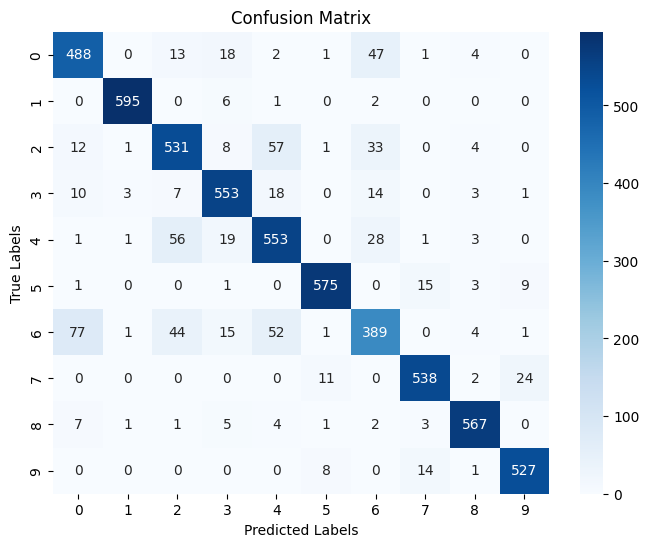

Model saved as pickle/model3_0.001.pkl
Epoch 1/50
Train Loss: 0.1940, Train Accuracy: 0.9603, Train Macro F1 Score: 0.9602
Val Loss: 0.5037, Val Accuracy: 0.8828, Val Macro F1 Score: 0.8841
--------------------------------------------------
Epoch 2/50
Train Loss: 0.1897, Train Accuracy: 0.9620, Train Macro F1 Score: 0.9619
Val Loss: 0.5307, Val Accuracy: 0.8793, Val Macro F1 Score: 0.8803
--------------------------------------------------
Epoch 3/50
Train Loss: 0.1928, Train Accuracy: 0.9620, Train Macro F1 Score: 0.9619
Val Loss: 0.5238, Val Accuracy: 0.8838, Val Macro F1 Score: 0.8845
--------------------------------------------------
Epoch 4/50
Train Loss: 0.1877, Train Accuracy: 0.9627, Train Macro F1 Score: 0.9626
Val Loss: 0.5009, Val Accuracy: 0.8918, Val Macro F1 Score: 0.8928
--------------------------------------------------
Epoch 5/50
Train Loss: 0.1902, Train Accuracy: 0.9619, Train Macro F1 Score: 0.9618
Val Loss: 0.5261, Val Accuracy: 0.8875, Val Macro F1 Score: 0.8885
--

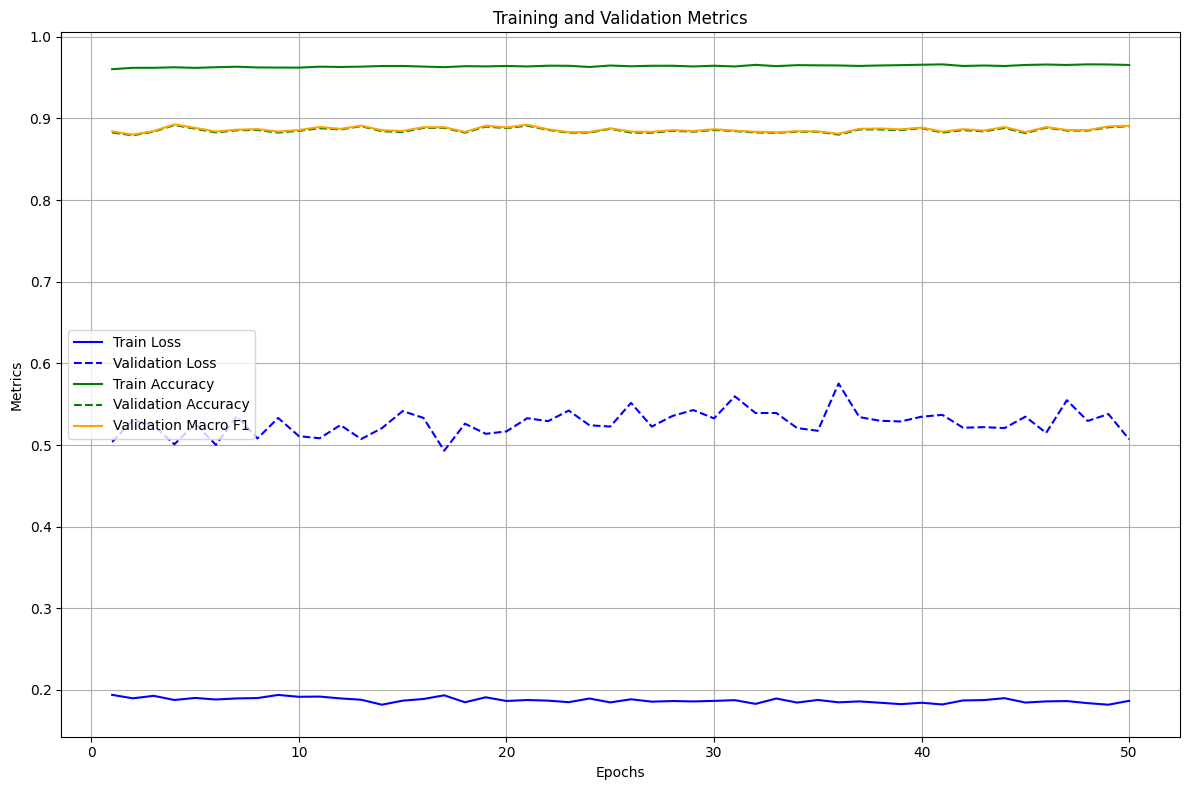

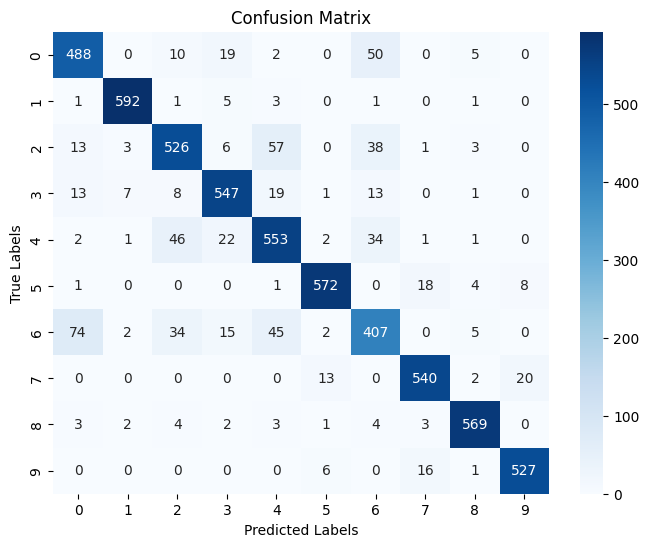

Model saved as pickle/model3_0.0005.pkl
Epoch 1/50
Train Loss: 0.1826, Train Accuracy: 0.9660, Train Macro F1 Score: 0.9659
Val Loss: 0.5392, Val Accuracy: 0.8878, Val Macro F1 Score: 0.8885
--------------------------------------------------
Epoch 2/50
Train Loss: 0.1801, Train Accuracy: 0.9674, Train Macro F1 Score: 0.9673
Val Loss: 0.5557, Val Accuracy: 0.8798, Val Macro F1 Score: 0.8807
--------------------------------------------------
Epoch 3/50
Train Loss: 0.1855, Train Accuracy: 0.9663, Train Macro F1 Score: 0.9663
Val Loss: 0.5312, Val Accuracy: 0.8855, Val Macro F1 Score: 0.8867
--------------------------------------------------
Epoch 4/50
Train Loss: 0.1792, Train Accuracy: 0.9669, Train Macro F1 Score: 0.9668
Val Loss: 0.5441, Val Accuracy: 0.8830, Val Macro F1 Score: 0.8838
--------------------------------------------------
Epoch 5/50
Train Loss: 0.1790, Train Accuracy: 0.9672, Train Macro F1 Score: 0.9671
Val Loss: 0.5413, Val Accuracy: 0.8862, Val Macro F1 Score: 0.8872
-

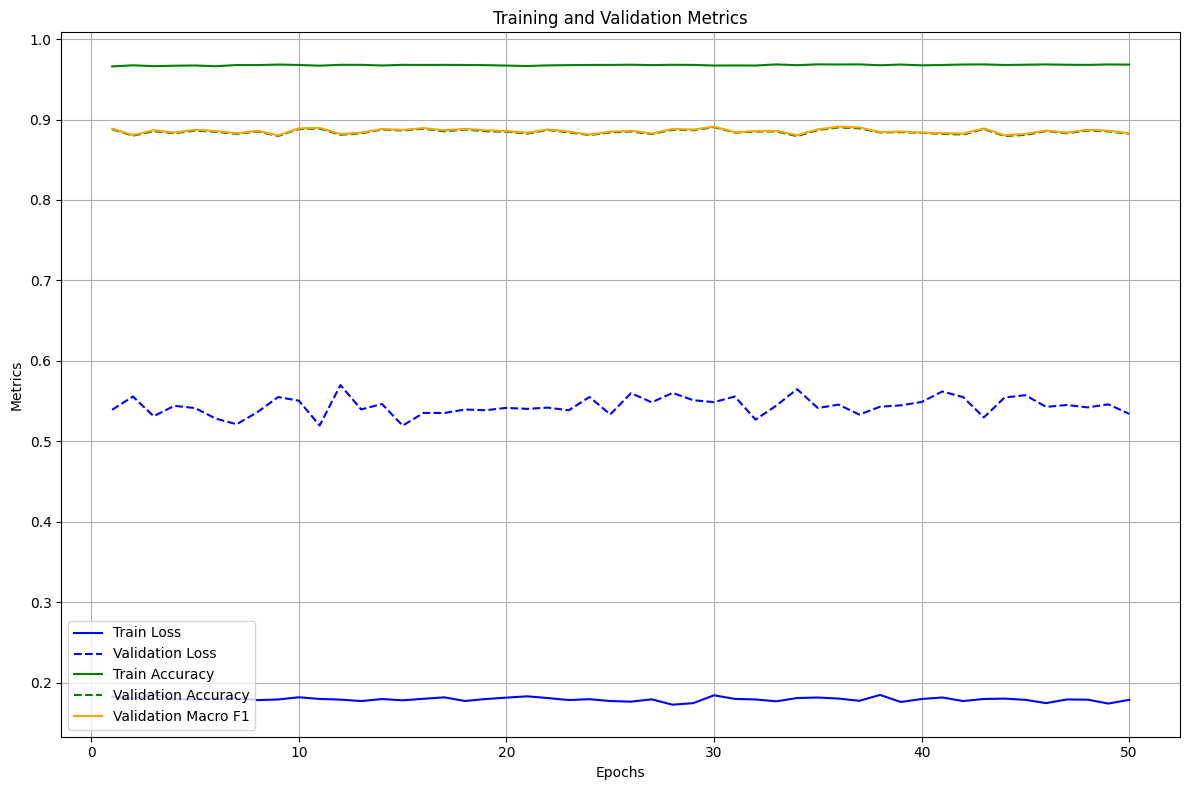

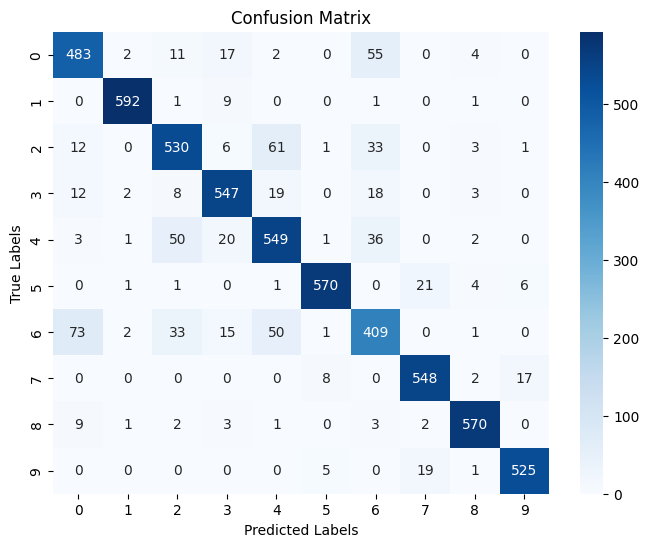

Model saved as pickle/model3_0.0001.pkl


In [902]:
layers_one = [
    DenseLayer(784, 512),             # First hidden layer with more neurons
    ReLU(),
    BatchNormalization(512),          # Normalize activations
    Dropout(0.2),                     # Dropout for regularization
    DenseLayer(512, 256),             # Second hidden layer
    ReLU(),
    BatchNormalization(256),
    Dropout(0.2),
    DenseLayer(256, 128),             # Third hidden layer
    ReLU(),
    BatchNormalization(128),
    Dropout(0.2),
    DenseLayer(128, 10),              # Output layer
    Softmax()
]

layers_two = [
    DenseLayer(784, 1024),            # First layer with a larger number of neurons
    ReLU(),
    BatchNormalization(1024),
    Dropout(0.2),
    DenseLayer(1024, 512),            # Second hidden layer
    ReLU(),
    BatchNormalization(512),
    Dropout(0.2),
    DenseLayer(512, 256),             # Third hidden layer
    ReLU(),
    BatchNormalization(256),
    Dropout(0.2),
    DenseLayer(256, 128),             # Fourth hidden layer
    ReLU(),
    BatchNormalization(128),
    Dropout(0.2),
    DenseLayer(128, 10),              # Output layer
    Softmax()
]


# layers_three = [
#     DenseLayer(784, 2048),            # First hidden layer with a very large number of neurons
#     ReLU(),
#     BatchNormalization(2048),
#     Dropout(0.2),
#     DenseLayer(2048, 1024),           # Second hidden layer
#     ReLU(),
#     BatchNormalization(1024),
#     Dropout(0.2),
#     DenseLayer(1024, 512),            # Third hidden layer
#     ReLU(),
#     BatchNormalization(512),
#     Dropout(0.2),
#     DenseLayer(512, 256),             # Fourth hidden layer
#     ReLU(),
#     BatchNormalization(256),
#     Dropout(0.2),
#     DenseLayer(256, 128),             # Fifth hidden layer
#     ReLU(),
#     BatchNormalization(128),
#     Dropout(0.2),
#     DenseLayer(128, 10),              # Output layer
#     Softmax()
# ]

layers_three = [
    DenseLayer(784, 256),         # First hidden layer with 256 neurons
    BatchNormalization(256),
    ReLU(),
    Dropout(0.2),
    DenseLayer(256, 64),          # Output layer with 10 neurons (one for each class)
    BatchNormalization(64),
    ReLU(),
    Dropout(0.2),
    DenseLayer(64,10),
    Softmax()
]




learning_rates = [0.005, 0.001, 0.0005, 0.0001]

for lr in learning_rates:
    adam = Adam(learning_rate=lr)
    
    # Train using model one (layers_one)
    model = FeedForwardNetwork(layers=layers_three, optimizer=adam, epochs=50)
    train_losses, train_accuracies, val_losses, val_accuracies, val_macro_f1s = model.train(train_loader, valid_loader)

    # Plot results
    model.plot_results(train_losses, train_accuracies, val_losses, val_accuracies, val_macro_f1s)

    # Confusion matrix plot
    model.plot_confusion_matrix(model, valid_loader)
    save_model(model, folder='pickle', filename=f'model3_{lr}.pkl')








In [914]:
model = FeedForwardNetwork(layers=layers_three, optimizer=adam, epochs=50)
model = load_model('pickle','model3_0.0005.pkl')
# model = load_model('pickle', 'model2_0.001.pkl')


# Assuming you have test data in `X_test` and true labels in `y_test`
# Make predictions
y_pred = model.evaluate_model(test_loader)




Model loaded from pickle/model3_0.0005.pkl
Accuracy: 0.8857
Sensitivity: 0.9959
Specificity: 0.9953
Precision: 0.8852
F1 Score: 0.8853
